<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/weights/DUDL_weights_weightchanges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

import copy

import sklearn.metrics as skm

# Import and process the data

In [2]:
# Import dataset
mnist_dataset = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter=',')

#Extract labels (number IDs) and remove from data
labels = mnist_dataset[:, 0]
data   = mnist_dataset[:, 1:]

# Normalize the data to a range of [0, 1]
data_norm = data / np.max(data)

# Convert to tensor
data_tensor   = torch.tensor(data_norm).float()
labels_tensor = torch.tensor(labels).long()

#  Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = \
    train_test_split(data_tensor, labels_tensor, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                          shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                          batch_size=test_data_set.tensors[0].shape[0])

# Create the DL model

In [3]:
def create_the_MNIST_net():
    """"
    FFN_WEIGHTHISTOGRAMS | MODEL_PERFORM_APRF_WINE | WEIGHTS_FREEZE_WEIGHTS | WEIGHTS_WEIGHTS_CHANGES
    """
    class mnist_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 64)

            # Hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            # Output layer
            self.output = nn.Linear(32, 10)

        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

            return self.output(x)
        
    # Create the model instance
    net = mnist_net()

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

    return net, loss_func, optimizer


# Create a function that trains the model

In [4]:
def train_the_model(net, loss_func, optimizer):
    """
    WEIGHTS_WEIGHTS_CHANGES
    """
    
    num_epochs = 60

    # Initialize accuracies as empties
    train_acc = []
    test_acc  = []
    losses = torch.zeros(num_epochs)

    # Initialize Weight change matrices
    # 4: 4 layers
    weight_change = np.zeros((num_epochs, 4))
    weight_conds  = np.zeros((num_epochs, 4))

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Store the weights for each layer
        pre_W = []
        for p in net.named_parameters():
            if ('weight' in p[0]):
                pre_W.append(copy.deepcopy(p[1].data.numpy()))
        
        # Activate training mode
        net.train()

        # Loop over training data batches
        batch_acc = []
        batch_loss = []

        for X, y in train_loader:

            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy just for this batch
            batch_acc.append(100 * torch.mean(((torch.argmax(y_hat, axis=1)) == y).float()).item())

            # Loss from this batch
            batch_loss.append(loss.item())

        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy 
        train_acc.append(np.mean(batch_acc))

        # Get average losses across the batches
        losses[epoch_i] = np.mean(batch_loss)

        # Test accuracy (NOTE: testing in batches!)    
        X, y = next(iter(test_loader))  # Extract x,y from test dataloader
        net.eval()                 # Activate testing mode
        with torch.no_grad():           # Deactivates autograd
            # pred_labels = torch.argmax(net(X), axis=1)
            pred_labels = net(X)

        # Compute accuracy
        test_acc.append(100 * torch.mean(((torch.argmax(pred_labels, axis=1)) == y).float()))

        # Finally, get the post-learning state of the weights
        for (i, p) in enumerate(net.named_parameters()):
          # int(i / 2): Only look for the weight
            if ('weight' in p[0]):
                # Condition number
                weight_conds[epoch_i, int(i / 2)] = np.linalg.cond(p[1].data)

                # Frobenius Norm of the weight change from pre-learning
                weight_change[epoch_i, int(i / 2)] = np.linalg.norm(pre_W[int(i / 2)] - p[1].data.numpy(), ord='fro')
    # End epochs
    # Function output
    return train_acc, test_acc, losses, net, weight_change, weight_conds, pre_W

# Run the model and plot the results

In [5]:
# Create the network
net, loss_func, optimizer = create_the_MNIST_net()

# Train the model
train_acc, test_acc, losses, net, weight_change, weight_conds, pre_W = train_the_model(net, loss_func, optimizer)

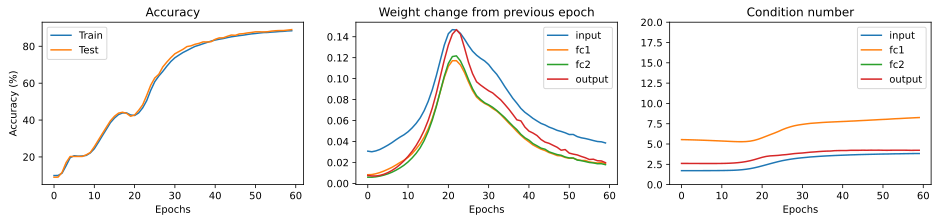

In [6]:
# Get a list of layer names
layer_name = []
for (i, p) in enumerate(net.named_parameters()):
    if ('weight' in p[0]):
        layer_name.append(p[0][:-7])

# Set up the plot
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

# Accuracy
ax[0].plot(train_acc)
ax[0].plot(test_acc)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy (%)')
ax[0].set_title('Accuracy')
ax[0].legend(['Train', 'Test'])

# Weight changes
ax[1].plot(weight_change)
ax[1].set_xlabel('Epochs')
ax[1].set_title('Weight change from previous epoch')
ax[1].legend(layer_name)

# Weight condition numbers
ax[2].plot(weight_conds)
ax[2].set_xlabel('Epochs')
ax[2].set_title('Condition number')
ax[2].legend(layer_name)
ax[2].set_ylim([0, 20])

plt.show()

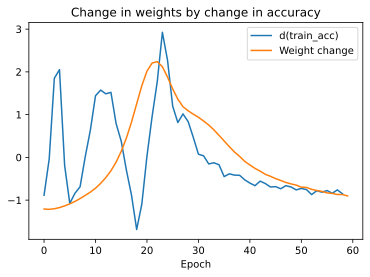

In [8]:
# Final inspection: check the derivative of accuracy against the weight change
# Normalize for scaling offsets
from scipy.stats import zscore

plt.plot(zscore(np.diff(train_acc)),             label='d(train_acc)')
plt.plot(zscore(np.mean(weight_change, axis=1)), label='Weight change')
plt.legend()
plt.title('Change in weights by change in accuracy')
plt.xlabel('Epoch')
plt.show()

# Additional explorations

In [ ]:
# 1) Re-run the training and visualization with L2 regularization (lambda=.01). Does that have a major noticeable effect?
# 
# 2) Then try with L1 regularization. (Hint: you might want to copy code from DUDL_overfitting_L1regu).
# 